In [1]:
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import j_acquire
import j_prep
import explore
import modeling

# NLP Project

### The Goal: Build a model that can predict what programming language a repository is, given the text of the README file.

# Planning

- Acauire data from github repositories from various topics
- Clean and prep it for nlp
- Explore it for patterns or groups that can be used for classifying
- Create models to predict programing language
- Deploy the best model on test data
- Present our findings

# Acquisition

We chose to look at 11 topics and scrape the readme files of the 30 most starred repos in each topic.
- Topics:
    1. algorithm
    2. bots
    3. data-visualization
    4. deep_learning
    5. javascript
    6. jupyter_notebook
    7. machine_learning
    8. nlp
    9. python
    10. Covid19
    11. testing

We saved the source code of each topic page into a text file for future access and to avoid any access issues. Our create_large_df function scrapes the repo names from each text file, applies Zach's scrape_github_data function to acquire the language type and readme in each repo, drops any null rows, and then combines everything into one large dataframe.

In [2]:
df = explore.make_initial_df()
print(f'There are {df.shape[0]} rows in the resulting dataframe.')

There are 298 rows in the resulting dataframe.


In [3]:
df.head()

,repo,language,readme_contents,basic_clean,clean_tokes,lemmatized,clean_lemmatized
0,CyC2018/CS-Notes,Java,"<div align=""center"">\r\n <a href=""https://g...",\r\n \r\n \r\n \r\n \r\n\r\n\r...,"[nbspnbsp, nbspnbsp, nbspnbspnbspnbspnbspnbspn...",nbspnbsp nbspnbsp nbspnbspnbspnbspnbspnbspnbsp...,nbspnbsp nbspnbsp nbspnbspnbspnbspnbspnbspnbsp...
1,TheAlgorithms/Python,Python,# The Algorithms - Python\n[![Gitpod Ready-to-...,the algorithms python\ngitpod readytocodehtt...,"[the, algorithms, python, gitpod, readytocodeh...",the algorithm python gitpod readytocodehttpsim...,algorithm python gitpod readytocodehttpsimgshi...
2,trekhleb/javascript-algorithms,JavaScript,# Algoritmos y Estructuras de Datos en JavaScr...,algoritmos y estructuras de datos en javascri...,"[algoritmos, y, estructuras, de, datos, en, ja...",algoritmos y estructuras de datos en javascrip...,algoritmos estructuras de datos en javascript ...
3,kdn251/interviews,Java,> * 原文地址：[github.com/kdn251/interviews](https:...,githubcomkdn251interviewshttpsgithubcomkdn25...,[githubcomkdn251interviewshttpsgithubcomkdn251...,githubcomkdn251interviewshttpsgithubcomkdn251i...,githubcomkdn251interviewshttpsgithubcomkdn251i...
4,yangshun/tech-interview-handbook,JavaScript,"<h1 align=""center"">Tech Interview Handbook</h1...",tech interview handbook\n\n\n \n \n \n \...,"[tech, interview, handbook, credits, illustrat...",tech interview handbook credit illustration by...,tech interview handbook credit illustration ya...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 7 columns):
repo                298 non-null object
language            298 non-null object
readme_contents     298 non-null object
basic_clean         298 non-null object
clean_tokes         298 non-null object
lemmatized          298 non-null object
clean_lemmatized    298 non-null object
dtypes: object(7)
memory usage: 16.4+ KB


# Preparation

Our prep_readme_data function accomplishes all of the basic clean operations, adds new columns tokenizing, stemming, and lemmatizing the readme contents. 

We also added a number of new features to make modeling easier. 
- General languages: grouping all the popular languages together, and adding the singletons into an 'other' category
- Number of individual words
- Number of unique words
- Number of links
- Counts of each .py, .js & .ipynb extensions

This file can be saved as a .csv for easy access and to save time.

In [5]:
df = explore.add_new_columns(df)
#df.to_csv('prepared_df.csv')
#df = pd.read_csv('prepared_df.csv')

In [6]:
df = explore.bin_link_counts(df)
df = explore.bin_word_counts(df)

Next we created a dataframe of every word in each of the popular languages: Python, JavaScript, Jupyter Notebooks, C++, TypeScript, Java, other, and all languages together.

In [7]:
word_counts = explore.make_word_counts_df(df)

Lastly, we created a vectorized dataframe with each of the words in the readmes are individual columns, and their importance in each readme are the values. We also added the new columns we created to this datafame for modeling purposes.

In [8]:
vectorized_df = explore.make_vectorized_df(df)

# Exploration

What are the 10 most common words in our dataset?

In [9]:
word_counts.sort_values(by='all', ascending=False)['all'].head(10)

de         1529
python     1366
data       1252
use        1237
model      1173
using      1038
1           992
code        937
install     881
network     762
Name: all, dtype: int64

What are the 10 most common words in each language?

In [10]:
# Python
word_counts.sort_values(by='python', ascending=False)['python'].head(10)

python     915
model      748
data       438
use        407
install    365
code       351
0          348
using      340
_          331
library    323
Name: python, dtype: int64

In [11]:
# JavaScript
word_counts.sort_values(by='javascript', ascending=False)['javascript'].head(10)

de            1496
e              488
que            379
const          366
covid19        366
1              346
para           336
use            329
javascript     318
um             308
Name: javascript, dtype: int64

In [12]:
# Jupyter Notebook
word_counts.sort_values(by='jupyter', ascending=False)['jupyter'].head(10)

data          280
python        279
tensorflow    253
using         240
model         216
use           209
network       205
notebook      199
learning      193
build         190
Name: jupyter, dtype: int64

In [13]:
# C++
word_counts.sort_values(by='c_plus', ascending=False)['c_plus'].head(10)

build      182
1          134
pytorch    133
onnx       130
c          113
support    112
cntk       109
given      106
using      106
2          102
Name: c_plus, dtype: int64

In [14]:
# TypeScript
word_counts.sort_values(by='typescript', ascending=False)['typescript'].head(10)

component    69
using        63
test         57
run          55
storybook    52
build        47
use          46
yarn         46
npm          46
data         44
Name: typescript, dtype: int64

In [15]:
# Java
word_counts.sort_values(by='java', ascending=False)['java'].head(10)

tree      106
binary     93
dp         90
two        88
search     84
dfs        69
table      67
hash       56
list       55
string     46
Name: java, dtype: int64

In [16]:
# Everything else
word_counts.sort_values(by='other', ascending=False)['other'].head(10)

al          374
et          373
network     218
deep        182
learning    176
go          163
code        160
neural      151
2016        147
data        136
Name: other, dtype: int64

- Now let's take a look at all the most frequently occuring words for each language all together

In [17]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,python,javascript,jupyter,c_plus,typescript,java,other
de,1529,10,1496,3,0,0,0,20
python,1366,915,41,279,102,5,0,24
data,1252,438,299,280,36,44,19,136
use,1237,407,329,209,101,46,22,123
model,1173,748,18,216,74,12,16,89
using,1038,340,180,240,106,63,8,101
1,992,308,346,90,134,20,12,82
code,937,351,153,147,67,42,17,160
install,881,365,138,190,71,37,3,77
network,762,262,10,205,61,0,6,218


- It looks like even repos that are predominately written in one language still reference other languages in the readme
- For example jupyter readmes have several mentions of python. 
- Perhaps these instances are due to comparing or contrasting strategies implemented in other languages

In [18]:
# code to regulate the size of plots for the rest of notebook
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

Text(0, 0.5, 'Most Common Words')

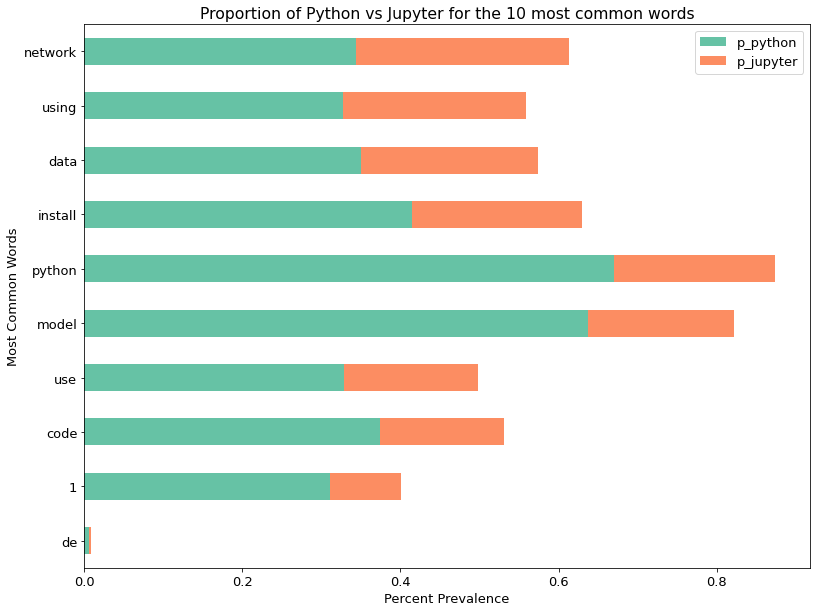

In [19]:
pal = sns.color_palette("Set2")


(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_jupyter=word_counts.jupyter / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_jupyter']]
 .tail(10)
 .sort_values('p_jupyter')
 .plot.barh(stacked=True, colors = pal))

plt.title('Proportion of Python vs Jupyter for the 10 most common words')
plt.xlabel('Percent Prevalence')
plt.ylabel('Most Common Words')

- Are there any words that can uniquely identify the programing language?

In [20]:
pd.concat([word_counts[word_counts.python == 0].sort_values(by='python').tail(10),
word_counts[word_counts.javascript == 0].sort_values(by='javascript').tail(10)]),
word_counts[word_counts.jupyter == 0].sort_values(by='jupyter').tail(10),
word_counts[word_counts.c_plus == 0].sort_values(by='c_plus').tail(10),
word_counts[word_counts.typescript == 0].sort_values(by='typescript').tail(10),
word_counts[word_counts.java == 0].sort_values(by='java').tail(10),
word_counts[word_counts.other == 0].sort_values(by='other').tail(10)

,all,python,javascript,jupyter,c_plus,typescript,java,other
eval_spec,2,2,0,0,0,0,0,0
eval_resultstxt,2,2,0,0,0,0,0,0
eval_pearsonr,1,1,0,0,0,0,0,0
eval_loss,2,2,0,0,0,0,0,0
eval_batch_size8,2,2,0,0,0,0,0,0
eval_all_ckpttrue,2,2,0,0,0,0,0,0
eval_all_ckpt,1,1,0,0,0,0,0,0
eval_accuracy,2,2,0,0,0,0,0,0
evaluatemodel,3,0,0,3,0,0,0,0
zyszyshttpsgithubcomzyszys,1,0,1,0,0,0,0,0


During our exploration, we learned that not all words are relevant to the majority of the readmes in our dataset. Therefore, we decided to handle this as such: 
1. We aggregated similar words together (ie, we added together the values for build, building and built; etc.).
2. We dropped all the words where the mean importance was less than 5%.
3. We added a 'politeness' score, adding together each of the 'polite' words like please and thank you.

Then, we split and scaled this dataset, and went ahead and made our prediction dataframes.

In [21]:
# Aggregate similar words
vectorized_df = explore.aggregate_columns(vectorized_df)
# Split & scale data, and make predictions dataframes
X_train_scaled, X_test_scaled, y_train, y_test, train_predictions, test_predictions = explore.get_splits(df, vectorized_df)
# Drop all words that aren't important
X_train_reduced, X_test_reduced = explore.prep_vectorized_df(X_train_scaled, X_test_scaled)

In [22]:
X_train_reduced.shape, X_test_reduced.shape

((208, 203), (90, 203))

In [23]:
# adding together X_train & y_train for exploration
X_train_reduced['y'] = y_train

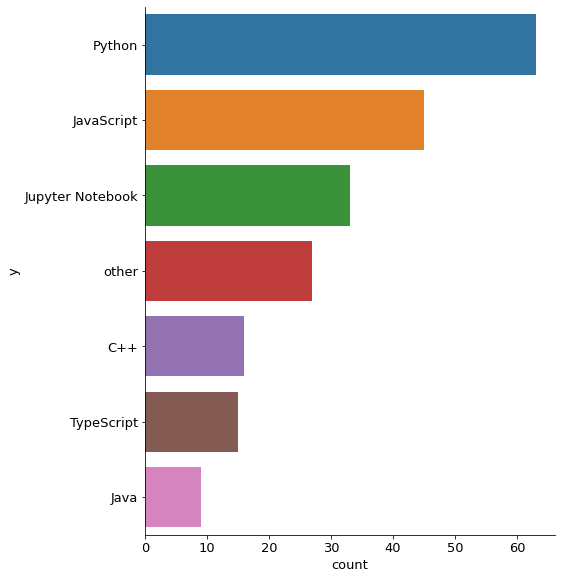

In [24]:
languages = ['Python', 'JavaScript', 'Jupyter Notebook', 'other', 'C++', 'TypeScript', 'Java']

sns.catplot(y='y', kind='count', data=X_train_reduced, height=8, order=languages)

In [25]:
languages = pd.concat([df.gen_language.value_counts(),
                    df.gen_language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

,n,percent
Python,90,0.302013
JavaScript,65,0.218121
Jupyter Notebook,47,0.157718
other,38,0.127517
C++,23,0.077181
TypeScript,22,0.073826
Java,13,0.043624


> Our dataset is mostly Python repos, but there are a quite a few of the other languages to compare.

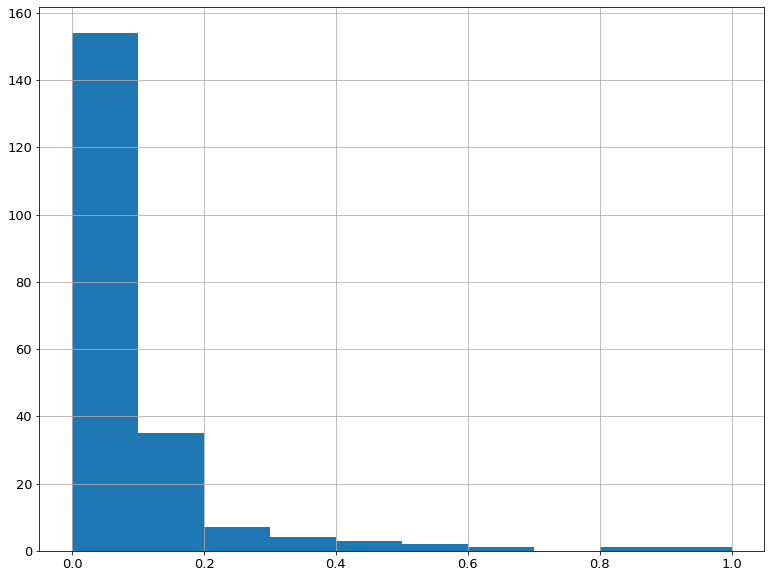

In [26]:
X_train_reduced.num_words.hist()

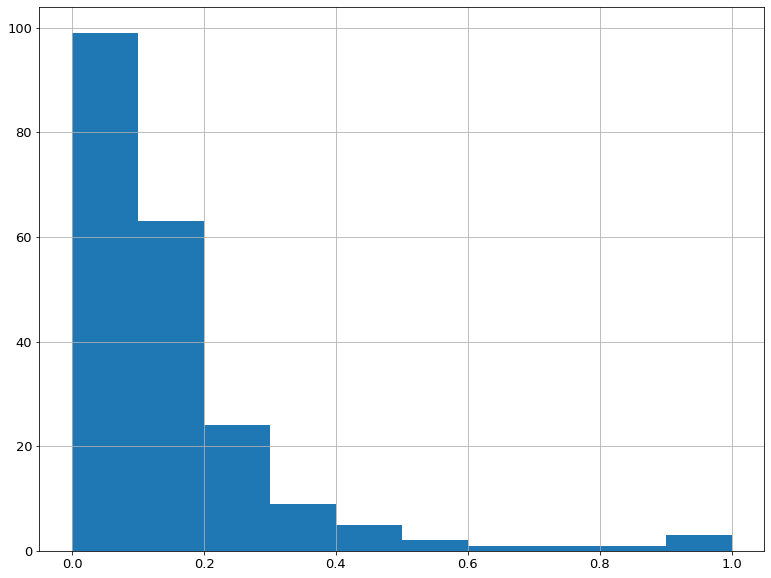

In [27]:
X_train_reduced.num_unique_words.hist()

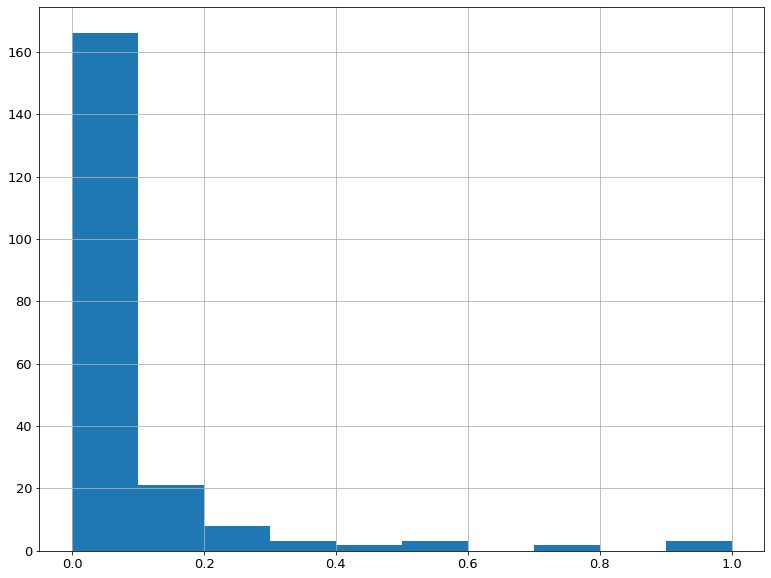

In [28]:
X_train_reduced.link_counts.hist()

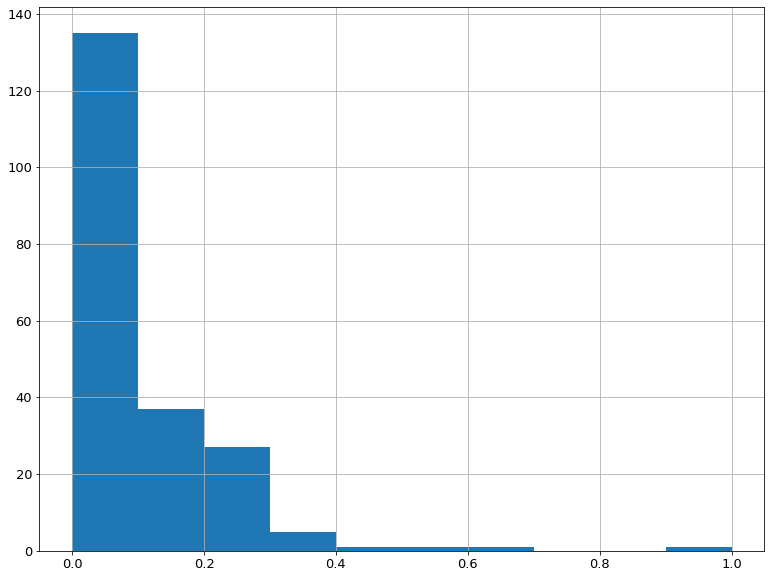

In [29]:
X_train_reduced.politeness.hist()

> Even our engineered and aggregated columns are heavily skewed to small numbers.

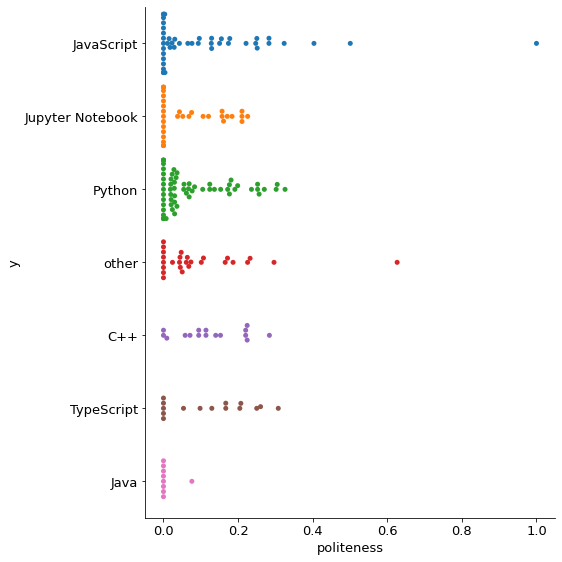

In [30]:
sns.catplot(y="y", x="politeness", kind="swarm", data=X_train_reduced, height=8)

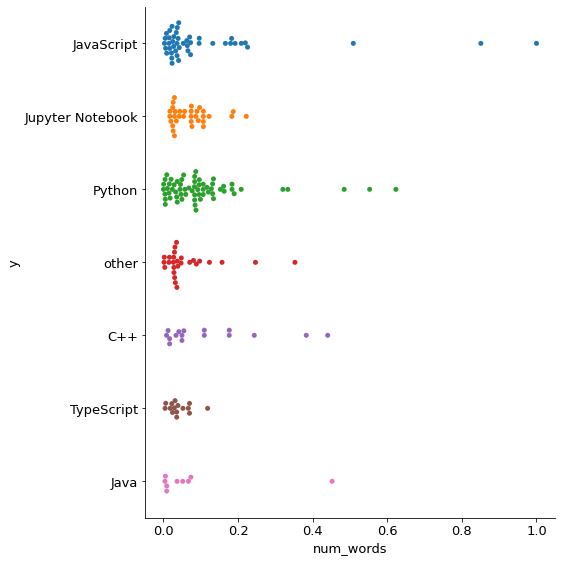

In [31]:
sns.catplot(y="y", x="num_words", kind="swarm", data=X_train_reduced, height=8)

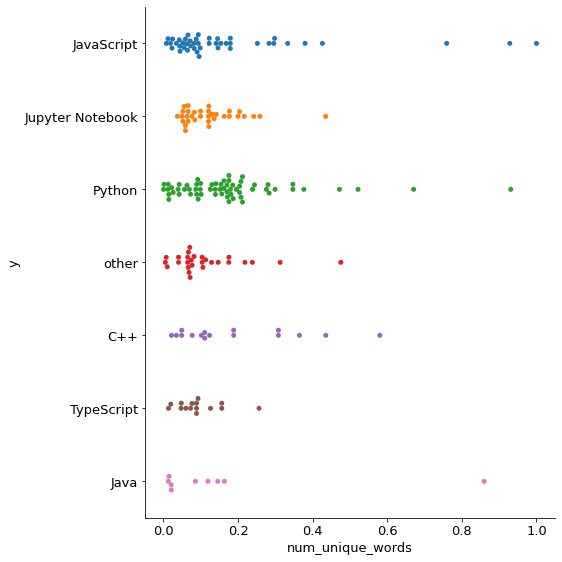

In [32]:
sns.catplot(y="y", x="num_unique_words", kind="swarm", data=X_train_reduced, height=8)

> It looks as though Jupyter Notebook repos use more words and more unique words than other repos.

#### Overall we have not yet come up with a feature that is obviously unique enough to classify each repo by language but we have successfully identified which of our features are likely to be noise and have removed them from our analysis

## Hypothesis Testing

In [33]:
H_0 = 'there is no difference between number of links for javascript repos and the overall average number of links.'
H_a = 'there is a difference between number of links for javascript repos and the overall average number of links.'
# We'll set a confidence level of 95% and an alpha of .05

In [34]:
javascript = df[df.gen_language == 'JavaScript']
alpha = 0.05

observed = pd.crosstab(javascript.link_bins, df.link_bins)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_0}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_a}')

Observed

[[37  0  0]
 [ 0 14  0]
 [ 0  0 14]]
---
Expected

[[21.06153846  7.96923077  7.96923077]
 [ 7.96923077  3.01538462  3.01538462]
 [ 7.96923077  3.01538462  3.01538462]]
---

chi^2 = 130.0000
p     = 0.0000
P value of 0.000 is less than alpha, so we reject the null hypothesis. there is no difference between number of links for javascript repos and the overall average number of links.


- $H_0$ there is no difference between number of words for python repos and the overall average number of words for all repos.
- $H_a$ there is a difference between number of words for python repos and the overall average number of words for all repos.

In [35]:
python = X_train_reduced[X_train_reduced['y'] == 'Python']
t, p = stats.ttest_1samp(python.num_words, X_train_reduced.num_words.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between number of words for python repos and the overall average number of words for all repos.'
H_a = 'There is a difference between number of words for python repos and the overall average number of words for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')


t = 0.973
p = 0.334
P value of 0.334 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between number of words for python repos and the overall average number of words for all repos.


- $H_0$ there is no difference between the politeness score for python repos and the overall politeness score for all repos.
- $H_a$ there is a difference between the politeness score for python repos and the overall politeness score for all repos.

In [36]:
python = X_train_reduced[X_train_reduced['y'] == 'Python']
t, p = stats.ttest_1samp(python.politeness, X_train_reduced.politeness.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between the politeness score for python repos and the overall politeness score for all repos.'
H_a = 'There is a difference between the politeness score for python repos and the overall politeness score for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = -1.096
p = 0.277
P value of 0.277 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between the politeness score for python repos and the overall politeness score for all repos.


- $H_0$ there is no difference between politeness score for JavaScript repos and the overall politeness score for all repos.
- $H_a$ there is a difference between politeness score for JavaScript repos and the overall politeness score for all repos.

In [37]:
java = X_train_reduced[X_train_reduced['y'] == 'JavaScript']
t, p = stats.ttest_1samp(java.politeness, X_train_reduced.politeness.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between politeness score for JavaScript repos and the overall politeness score for all repos.'
H_a = 'There is a difference between politeness score for JavaScript repos and the overall politeness score for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = 0.977
p = 0.334
P value of 0.334 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between politeness score for JavaScript repos and the overall politeness score for all repos.


- $H_0$ there is no difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.
- $H_a$ there is a difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.

In [38]:
jupyter = X_train_reduced[X_train_reduced['y'] == 'Jupyter Notebook']
t, p = stats.ttest_1samp(jupyter.num_words, X_train_reduced.num_words.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.'
H_a = 'There is a difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = -2.246
p = 0.032
P value of 0.032 is less than alpha, so we reject the null hypothesis. There is a difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.


> AHA! Finally we found something that is significant!

# Modeling

In [39]:
# Drop the y column from X_train_reduced for modeling
X_train_reduced = X_train_reduced.drop(columns='y')

### We created and evaluated multiple models:
------------------------------------------------------------------------------------------------------------------
A baseline was established which predicts the most common programing language present in our corpus: __Python__.
- Logistic Regression:
> - No hyperperameters were adjusted on this model 
- Random Forest
> - Minimul leaf samples was set to 3
> - Max depth was set to 10
- K Nearest Neighbors
 > - Neighbors are set to 2
 > - Weights are uniform

In [40]:
train_predictions, test_predictions = modeling.make_predictions_df(X_train_reduced, X_test_reduced, y_train, train_predictions, test_predictions)
modeling.train_evaluation(train_predictions)

Evaluation Metrics for Logistic Regression Model


Accuracy: 91.83%
----------------------------------------------------------------------------------------------
Confusion Matrix
actual            C++  Java  JavaScript  Jupyter Notebook  Python  TypeScript  \
lr_predictions                                                                  
C++                14     0           0                 0       0           0   
Java                0     5           0                 0       0           0   
JavaScript          2     0          45                 1       2           1   
Jupyter Notebook    0     1           0                28       0           0   
Python              0     3           0                 3      61           0   
TypeScript          0     0           0                 0       0          14   
other               0     0           0                 1       0           0   

actual            other  
lr_predictions           
C++                   0  
Java        

- Based on the accuracy metric, it looks like the __Random Forest Model__ is our best performer. 
- Below is a peak at the train_predictions dataframe which contains the predictions of each model

In [41]:
train_predictions

,actual,baseline,lr_predictions,rf_predictions,knn_predictions
279,JavaScript,Python,JavaScript,JavaScript,Java
156,Jupyter Notebook,Python,Jupyter Notebook,Jupyter Notebook,Jupyter Notebook
31,Python,Python,Python,Python,JavaScript
125,JavaScript,Python,JavaScript,JavaScript,JavaScript
110,other,Python,other,other,Java
...,...,...,...,...,...
18,JavaScript,Python,JavaScript,JavaScript,JavaScript
213,Jupyter Notebook,Python,Python,Java,Jupyter Notebook
39,Python,Python,Python,Python,Python
106,Jupyter Notebook,Python,Jupyter Notebook,Jupyter Notebook,Jupyter Notebook


### Next we applied our best model on the test data and evaluated it for all the same metrics

In [42]:
modeling.test_evaluation(test_predictions)

Evaluation Metrics for Random Forest Model


Accuracy: 55.56%
----------------------------------------------------------------------------------------------
Confusion Matrix
actual            C++  Java  JavaScript  Jupyter Notebook  Python  TypeScript  \
rf_predictions                                                                  
C++                 3     0           0                 0       0           0   
Java                0     1           0                 0       1           0   
JavaScript          0     1          18                 1       2           5   
Jupyter Notebook    0     0           0                 4       0           1   
Python              4     1           2                 9      24           1   
other               0     1           0                 0       0           0   

actual            other  
rf_predictions           
C++                   0  
Java                  2  
JavaScript            2  
Jupyter Notebook      1  
Python               

*Our __best__ performing model on training data was the Random Forest Model with 95% accuray and it was deployed on the test data. Final model performance was 57% accuracy.*

- Here you can see exactly what each model predicted for each repository

In [43]:
test_predictions

,actual,baseline,lr_predictions,rf_predictions,knn_predictions
198,Python,Python,Python,Python,Python
68,Python,Python,Python,Python,JavaScript
67,Java,Python,other,other,JavaScript
19,other,Python,Python,Python,JavaScript
145,Jupyter Notebook,Python,Python,Python,Python
...,...,...,...,...,...
168,Python,Python,Python,Python,JavaScript
124,JavaScript,Python,JavaScript,JavaScript,JavaScript
118,JavaScript,Python,JavaScript,JavaScript,Jupyter Notebook
139,Jupyter Notebook,Python,Jupyter Notebook,Python,C++


# Conclusions

### Ultimately our best model improved predictions by 90% over the baseline model
- Each model we created struggled to predict programming languages that appeared less frequently in our corpus of documents. 
- Natural language processesing appears to be especially prone to overfitting though with some recursive fine-tuning, it can be used to correctly classify documents according to thier programming language.

## Moving forward:
- Gather a larger corpus
- Consider handling outliers
- Remove more common words that add no meaning to the text to further reduce noise